In [ ]:
import tensorflow as tf
from keras import backend as K

In [ ]:
from tensorflow.keras.models import Model,Sequential
import numpy as np
from tensorflow.keras.layers import Flatten,Conv2D,Input, MaxPool2D, Dense, Dropout, Lambda
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist


In [ ]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
def showImg(x,y=None,index=100,numImg=6):
  for i in range(numImg):
    figure=plt.subplot(4,4,i+1)
    figure.axis("off")

    plt.imshow(x[index+i],cmap="Greys")
    plt.title(y[i+index])
  plt.show()

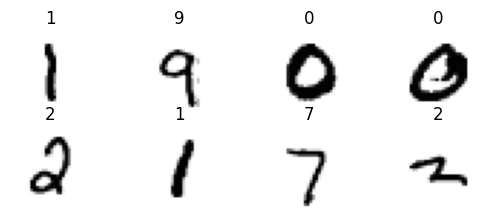

In [ ]:
showImg(x_train,y_train,22222,8)

In [ ]:
#create pairs : since we need to pass a pair of objects and a label indicating whether objects are equal or not

def createPair(x,y,min_pair=1000): #where min_pair=no of equal pairs we want in the dataset
  pairs=[]
  label=[]
  equal=0
  #we have 10 classes: 0-9
  #index=1, all images where label = 1
  index = [np.where(y==i)[0] for i in range(10)]

  for item in range(len(x)):
    if equal<min_pair:
      random_index = np.random.randint(len(index[y[item]]))
      num_pair = index[y[item]][random_index]
      equal+=1
    else:
      num_pair = np.random.randint(len(x))
    label += [float(y[item]==y[num_pair])]
    pairs += [[x[item],x[num_pair]]]

  return np.array(pairs), np.array(label)

In [ ]:
trainPair,trainLabel = createPair(x_train,y_train,3000)
testPair, testLabels = createPair(x_test,y_test)

In [ ]:
trainPair.shape

(60000, 2, 28, 28)

In [ ]:
def showPair(x,y,img):

  fig = plt.subplot(1,2,1)
  plt.imshow(x[img][0])
  plt.axis("off")
  fig = plt.subplot(1,2,2)
  plt.imshow(x[img][1])
  plt.axis("off")
  plt.title(y[img])
  plt.show()

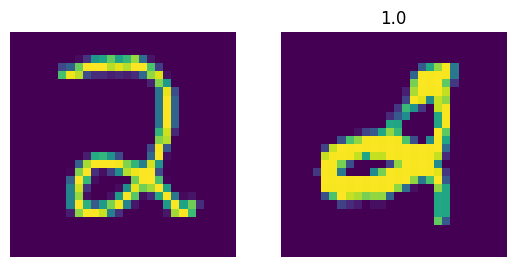

In [ ]:
showPair(trainPair,trainLabel,432)

In [ ]:
def init_base_model(inputshape=(28,28,1)):
  model = Sequential([
      Conv2D(32,(3,3),activation="relu",input_shape=inputshape),
      MaxPool2D(pool_size=(2,2)),
      Conv2D(16,(3,3),activation="relu"),
      MaxPool2D(pool_size=(2,2)),
      Flatten(),

      Dense(512,activation="relu"),
      Dense(256,activation="relu"),
      Dense(128,activation="relu")
  ])
  return model

In [ ]:
base_model = init_base_model()

In [ ]:
input_layer_left = Input(shape=(28,28,1),name="lwft input")
vec_output_left = base_model(input_layer_left)

input_layer_right = Input(shape=(28,28,1),name="right input")
vec_output_right = base_model(input_layer_right)

In [ ]:
# Loss function -- Contrastive loss / Triplet Loss
def euclidean_dist(vectors):
  x,y=vectors
  sum_sq = K.sum(K.square(x-y),axis=1,keepdims=True)
  return K.sqrt(K.maximum(sum_sq,K.epsilon()))

def euclidean_dist_outputshape(shapes):
  shape1,shape2 = shapes
  return (shape1[0],1)

def constrastiveLossWrapper(margin):
  def constrastiveLoss(y_true,y_pred):
    sq_pred = K.square(y_pred)
    margin_sq = K.square(K.maximum(margin-y_pred,0))
    return (float(y_true*sq_pred)+float((1-y_true)*margin_sq))
  return constrastiveLoss

In [ ]:
output = Lambda(euclidean_dist, name="output_layer",output_shape = euclidean_dist_outputshape)([vec_output_left, vec_output_right])

model = Model(inputs = [input_layer_left, input_layer_right], outputs = output)

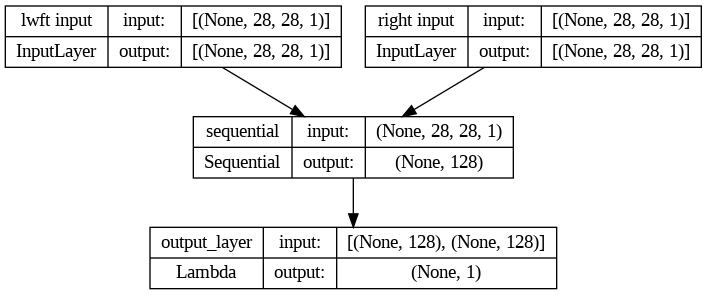

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
def calcAccuracy(pred,labels):
  return labels[pred.ravel()<0.5].mean()

def accuracy(y_true, y_pred):
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

optimizers = tf.keras.optimizers.Adam()
loss = constrastiveLossWrapper(1)

model.compile(loss=loss,optimizer=optimizers,metrics=[accuracy])

In [ ]:
history = model.fit([trainPair[:,0],trainPair[:,1]],trainLabel, epochs=20, batch_size=32,validation_data=([testPair[:,0],testPair[:,1]],testLabels))

Epoch 1/20
1875/1875 [==============================] - 28s 6ms/step - loss: 0.9405 - accuracy: 0.8601 - val_loss: 0.0960 - val_accuracy: 0.8784
Epoch 2/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0565 - accuracy: 0.9279 - val_loss: 0.0574 - val_accuracy: 0.9325
Epoch 3/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0346 - accuracy: 0.9619 - val_loss: 0.0440 - val_accuracy: 0.9556
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0254 - accuracy: 0.9748 - val_loss: 0.0396 - val_accuracy: 0.9606
Epoch 5/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0232 - accuracy: 0.9779 - val_loss: 0.0254 - val_accuracy: 0.9767
Epoch 6/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0188 - accuracy: 0.9821 - val_loss: 0.0273 - val_accuracy: 0.9756
Epoch 7/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0159 - accuracy: 0.9851 - val_loss: 0.0199 - val_ac

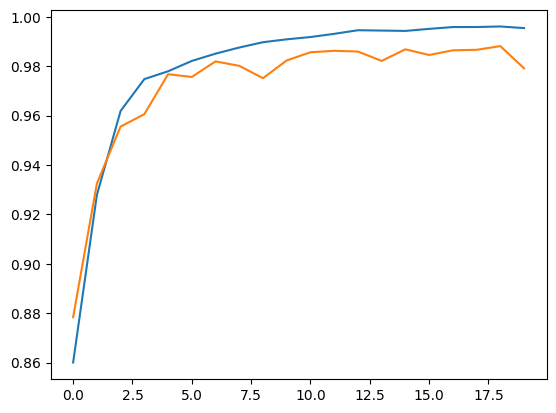

In [ ]:
plt.plot(history.history['accuracy'],label="train acc")
plt.plot(history.history['val_accuracy'],label="test acc")

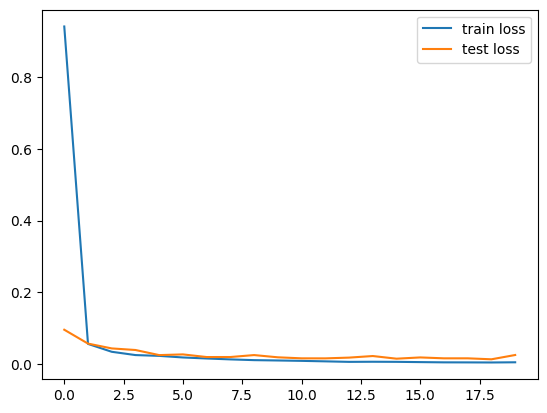

In [ ]:
plt.plot(history.history['loss'],label="train loss")
plt.plot(history.history['val_loss'],label="test loss")
plt.legend()

In [ ]:
y_pred = model.predict([testPair[:,0],testPair[:,1]])

313/313 [==============================] - 1s 2ms/step


In [ ]:
def vis_resulats(leftimg,rightimg,pred):
  fig = plt.subplot(1,2,1)
  plt.imshow(leftimg)
  plt.axis("off")
  fig = plt.subplot(1,2,2)
  plt.imshow(rightimg)
  plt.axis("off")
  plt.title(pred)
  plt.show()

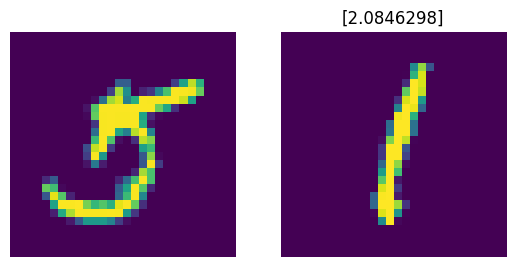

In [ ]:
vis_resulats(testPair[:,0][9117],testPair[:,1][9117],y_pred[9117])

In [ ]:
2